## Modèles de Recommandation  
Dans ce notebook, on va implémenter nos différents modèles de recommandation 
(Filtrage Collaboratif, Filtrage basé sur le contenu,notre approche hybride), ensuite, on va élaborer nos différents protocoles éxpérimentaux afin d'évaluer chaque modèle sur de différentes configurations .  

In [ ]:
import seaborn as sns
import json
from os.path import join
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
#import tensorflow.compat.v1 as tf
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
path = r"C:\Users\yacin\Desktop\projet de recherche\ressources"
outputFile = r"C:\Users\yacin\Desktop\projet de recherche\ressources\reviews.csv"

## Récupérer les avis des utilisateurs sur nos séries 

In [2]:
# Cellule à executer un seule fois pour créer le fichier avec les reviews dans le répertoire r"C:\Users\yacin\Desktop\projet de recherche\ressources\"

#serieFile = open(join(path, "serie_names.pkl"), "rb")
# charger les noms de séries qu'on a 
#series_names = pickle.load(serieFile)
#print(series_names)
#files = ["part-01", "part-02", "part-03", "part-04", "part-05", "part-06"]
#for nomFichier in files :
#    with open(join(path, nomFichier+".json")) as f:
#        data = json.load(f)
#    f.close()

#    df = pd.DataFrame.from_dict(data)
#    df = df[["reviewer", "movie", "rating"]]
#    df["movie"] = df["movie"].apply(lambda m : re.sub("[_]+|^[\d]+|.txt$|\(.*\)|BBC", " ", m).strip())
#    df2=df.loc[df["movie"].isin(series_names)]
#    print("number of reviews conserved : {}".format(df2.shape[0]))
#    print("number of unique series in the reviews conserved : {}".format(len(df2["movie"].unique())))
#    df2.to_csv(outputFile,header=False,index=False, mode="a")

## Analyse de données récupérées sur les avis des utilisatuers :

In [3]:
reviews = pd.read_csv(outputFile, names= ["reviewer", "serie", "rating"])

In [4]:
reviews.dropna(inplace=True)    # On supprime les lignes où il y'a des nulls

In [5]:
number_reviews_per_user = reviews.drop(columns="rating").groupby(by="reviewer").count().sort_values("serie")

In [6]:
print("nombre d'utilisateurs uniques qu'on a: {}".format(number_reviews_per_user.shape[0]))
number_reviews_per_user.describe()

nombre d'utilisateurs uniques qu'on a: 174220


serie
count  174220.000000
mean        1.559924
std         4.386478
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       840.000000

In [7]:
# garder que les utilisateurs avec au moins k avis donnés
k = 3
users = number_reviews_per_user[number_reviews_per_user["serie"] > k].index
print("nombre d'utilisateurs uniques qu'on a après la suppression des utilisateurs avec moins de {} avis: {}".format(k, len(users)))

nombre d'utilisateurs uniques qu'on a après la suppression des utilisateurs avec moins de 3 avis: 7743


In [8]:
print("nombre d'avis avant la suppression des utilisateurs avec moins de {} avis : {}".format(k, reviews.shape[0]))
reviews2 =reviews.loc[reviews["reviewer"].isin(users)]
print("nombre d'avis après la suppression des utilisateurs avec moins de {} avis : {}".format(k, reviews2.shape[0]))

nombre d'avis avant la suppression des utilisateurs avec moins de 3 avis : 271770
nombre d'avis après la suppression des utilisateurs avec moins de 3 avis : 76912


In [9]:
print("Le nombre de séries différentes dans les avis après filtrage : {}".format(len(reviews2["serie"].unique())))

Le nombre de séries différentes dans les avis après filtrage : 2128


In [10]:
reviews2.drop(columns="serie").groupby(by="rating").count().plot(kind="bar")

<AxesSubplot:xlabel='rating'>

## Construction de la matrice des avis d'utilisateurs :

In [12]:
# Mapping of users and series to integers (ids)
le_users = LabelEncoder()
reviews2["user_id"] = le_users.fit_transform(reviews2.loc[:,"reviewer"])
le_series = LabelEncoder()
reviews2["serie_id"] = le_series.fit_transform(reviews2.loc[:,"serie"])

serie_ID={ row["serie"] : row["serie_id"] for _ , row in reviews2[["serie","serie_id"]].iterrows()}

reviews2 = reviews2.drop(columns=["reviewer", "serie"])

<ipython-input-12-63f9f329ba0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews2["user_id"] = le_users.fit_transform(reviews2.loc[:,"reviewer"])
<ipython-input-12-63f9f329ba0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews2["serie_id"] = le_series.fit_transform(reviews2.loc[:,"serie"])


## Popularity model
on recommande au utilisateurs les series les plus populaires qu'ils n'ont pas vu:

In [13]:
def popularity_model (reviews, userid, topN=10):
    """
    retourne les topN séries les plus populaires que l'utilisateur n'a pas regarder déjà
    """
    watched_series = reviews.loc[reviews["user_id"] == userid, "serie_id"]
    sorted_series =  reviews.drop(columns="user_id").groupby(by="serie_id").sum().sort_values("rating", ascending=False).index.tolist()
    for w in watched_series:
        if w in sorted_series:
            sorted_series.remove(w)
    
    return  sorted_series[:topN]

In [14]:
popularity_model (reviews2, 24757, 10)

[2095, 126, 1925, 780, 586, 1520, 217, 528, 1670, 72]

## Factorisation de Matrice :  Premier essai :

In [1]:
df = reviews2.pivot_table(index='user_id', columns='serie_id', values='rating').fillna(0)
df.iloc[10:30, :20]

NameError: name 'reviews2' is not defined

In [16]:
matrix = df.values
sparse_matrix = csr_matrix(matrix)

In [17]:
nbr_features = 20
U, sigma, V = svds(sparse_matrix, k = nbr_features)
sigma = np.diag(sigma)

In [19]:
predictions = np.dot(np.dot(U, sigma), V) 

## Construction d'un  train/test set

Ici, pour simplifier ,On prendra un exemple sur 5 dans le test set.

In [21]:
train_indexes,test_indexes = [],[]

for index in range(len(reviews2)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

train_ratings = reviews2.iloc[train_indexes].copy()
test_ratings = reviews2.iloc[test_indexes].copy()


##  Implémentation des prédicteurs de base ( baselines )


First, before digging into more complicated models, we'll implement three really simple baselines:

- The global mean $\mu$
- The user mean $b_u$
- The item mean $b_i$

Indeed, the rating distribution is not uniform at all (it looks more normal). Therefore, the means are good baselines.

In [22]:
MEAN = train_ratings["rating"].mean()
USER_MEANS = train_ratings.groupby("user_id")["rating"].mean()
ITEM_MEANS = train_ratings.groupby("serie_id")["rating"].mean()


def mean_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    
    return MEAN

def user_mean_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    if user in USER_MEANS:
        return USER_MEANS[user] 
    else:
        return 0

def item_mean_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    
    if item in ITEM_MEANS:
        return ITEM_MEANS[item] 
    else:
        return 0


In [23]:
test_ratings.loc[:,"mean_prediction"] = test_ratings[["user_id","serie_id"]].apply(mean_rating_pred,axis=1)
test_ratings.loc[:,"muser_prediction"] = test_ratings[["user_id","serie_id"]].apply(user_mean_rating_pred,axis=1) 
test_ratings.loc[:,"mitem_prediction"] = test_ratings[["user_id","serie_id"]].apply(item_mean_rating_pred,axis=1) 

test_ratings.head(5)

rating  user_id  serie_id  mean_prediction  muser_prediction  \
3      6.0     6355      1210         6.873198          8.583333   
23     7.0     2795      1054         6.873198          7.913043   
53    10.0     4062       586         6.873198          9.333333   
72     9.0     3259       143         6.873198          8.888889   
87     6.0     3482       816         6.873198          8.315789   

    mitem_prediction  
3           5.446154  
23          5.500000  
53          7.515856  
72          7.181818  
87          5.375000

## Evaluation metrics:

In explicit collaborative filtering there are three common metrics to compare a ground truth $x$ to a predicted $\hat{x}$:

- Mean Average Error (MAE) : $$\frac{1}{n}\sum^n|(x-\hat{x})|$$
- Mean Squared Error (MSE) : $$\frac{1}{n}\sum^n(x-\hat{x})^2$$
- Rooted Mean Squared Error (RMSE) : $$\sqrt{\frac{1}{n}\sum^n(x-\hat{x})^2}$$

In [24]:
from math import sqrt

def mae(predictions,truth):
    return np.sum(np.abs(predictions - truth)) / len(truth)

def mse(predictions,truth):
    return np.sum((predictions - truth)**2) / len(truth)

def rmse(predictions,truth):
    return np.sqrt(mse(predictions,truth))


def all_metrics(predictions,truth):
    return [f(predictions,truth) for f in [mae,mse,rmse]]

In [25]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction
metrics                                                     
mae             2.120026          1.823098          1.984254
mse             6.886805          5.967090          6.366662
rmse            2.624272          2.442763          2.523225

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

# Basic explicit collaborative filtering models - using surprise library

In [26]:
#!pip3 install scikit-surprise

In [27]:
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(train_ratings[['user_id', 'serie_id', 'rating']], Reader(rating_scale=(1, 10)))

In [28]:
BaselineModel = BaselineOnly()
BaselineModel.fit(data.build_full_trainset())

Estimating biases using als...


In [29]:
def opt_bl_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    
    prediction = BaselineModel.predict(user,item)
    
    return prediction.est

test_ratings["opt_bl_prediction"] = test_ratings[["user_id","serie_id"]].apply(opt_bl_rating_pred,axis=1) 

test_ratings

rating  user_id  serie_id  mean_prediction  muser_prediction  \
3          6.0     6355      1210         6.873198          8.583333   
23         7.0     2795      1054         6.873198          7.913043   
53        10.0     4062       586         6.873198          9.333333   
72         9.0     3259       143         6.873198          8.888889   
87         6.0     3482       816         6.873198          8.315789   
...        ...      ...       ...              ...               ...   
326604     9.0     3233       201         6.873198          7.214286   
326615     8.0     6542       201         6.873198          5.666667   
326639     9.0     1051       201         6.873198          7.000000   
326657     7.0     3483       248         6.873198          5.785714   
326688     8.0      905      1574         6.873198          7.578947   

        mitem_prediction  opt_bl_prediction  
3               5.446154           6.438411  
23              5.500000           7.465732  
53              7.515856           7.965343  
72              7.181818           8.027591  
87              5.375000           6.896705  
...                  ...                ...  
326604          8.049180           8.148492  
326615          8.049180           7.610127  
326639          8.049180           8.051438  
326657          6.491228           6.003023  
326688          6.000000           6.791477  

[15383 rows x 7 columns]

## SVD Algorithm :

In [30]:
svcModel = SVD()         #n_epochs=1600, lr_all=0.005)
svcModel.fit(data.build_full_trainset())

## Use the surprise SVD Implementation to predict missing ratings.

In [31]:
def svd_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    
    prediction = svcModel.predict(user, item)
    
    return prediction[3]

test_ratings["svd_prediction"] = test_ratings[["user_id","serie_id"]].apply(svd_rating_pred,axis=1) 

<AxesSubplot:>

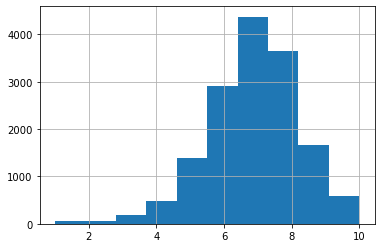

In [32]:
test_ratings["svd_prediction"].hist()

### KNN algorithms:

In [33]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans


sim_options = {'name': 'cosine'}
KNNmodel = KNNBasic(sim_options=sim_options)
KNNmodel.fit(data.build_full_trainset())

def knn_rating_pred(user_item):
    user = user_item["user_id"]
    item = user_item["serie_id"]
    
    prediction =KNNmodel.predict(user,item)
    
    return prediction.est## To complete

test_ratings["knn_prediction"] = test_ratings[["user_id","serie_id"]].apply(knn_rating_pred,axis=1) 

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["rating"])
results["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["rating"])
results["knn_prediction"] = all_metrics(test_ratings["knn_prediction"],test_ratings["rating"])

results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             2.120026          1.823098          1.984254   
mse             6.886805          5.967090          6.366662   
rmse            2.624272          2.442763          2.523225   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.810303        1.790254        1.999468  
mse               5.290847        5.372186        6.545606  
rmse              2.300184        2.317798        2.558438  

---Best Models / Metrics: ---


metrics
mae        svd_prediction
mse     opt_bl_prediction
rmse    opt_bl_prediction
dtype: object

## Mean Reciprocal Rank : (MRR)

In [35]:
test_list = [[0,0,1],[0,1,0],[1,0,0],[0,0,0]]

def rr(list_items):
    relevant_indexes = np.asarray(list_items).nonzero()[0]
    
    if len(relevant_indexes) > 0:
        
        #NOTE:
        # relevant_indexes[0] <= Contains the index of the 1st relevant item ([0,0,1] => 2)
        
        return 1/(relevant_indexes[0]+1)# To Complete
    else:
        #print("Pas d'élements pertinents dans la liste")
        return 0.0# To Complete

def mrr(list_list_items):
    return np.array([rr(list) for list in list_list_items]).mean()# To Complete

mrr(test_list) #0.4583333333333333

0.4583333333333333

In [38]:
def util_mrr (training_set, test_set):
    already_seen = (
    training_set 
    .groupby("user_id")["serie_id"]
    .apply(list)
    .to_dict()
    )

    ground_truth = (
        test_set[test_set.rating >= 8] 
        .groupby("user_id")["serie_id"]
        .apply(list)
        .to_dict()
        )
    
    return already_seen, ground_truth

In [39]:
already_seen = (
    train_ratings 
    .groupby("user_id")["serie_id"]
    .apply(list)
    .to_dict()
    )

ground_truth = (
    test_ratings[test_ratings.rating >= 8] 
    .groupby("user_id")["serie_id"]
    .apply(list)
    .to_dict()
    )
print(len(already_seen))
print(len(ground_truth))
print(len(train_ratings))

7741
3855
61529


## Les séries disponibles : 

In [40]:
existing_items = set(train_ratings["serie_id"].unique())
print("The recommender system will have to pick a few items from",len(existing_items),"possible items")

The recommender system will have to pick a few items from 2087 possible items


In [41]:
def model_rating_pred(modele,user,item):
    prediction = modele.predict(user,item) 
    return prediction.est

In [42]:
def build_relevance_list (model , ground_truth, already_seen, existing_items):
    list_of_rel = []
    for user,will_see in ground_truth.items():
        rel_list = []
        will_see = set(will_see)
        if user in already_seen:
            has_seen = set(already_seen[user])
            can_see = [(mid,model_rating_pred(model,user,mid)) for mid in existing_items - has_seen]


            for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
                if movie in will_see:
                    rel_list.append(1)
                    break
                else:
                    rel_list.append(0)    
            if len(rel_list) <1:
                rel_list.append(0)
            #rel_list[-1] = 1 # when no relevant item exist
            list_of_rel.append(rel_list)
        
    return list_of_rel

In [43]:
list_of_rel = []
for user,will_see in ground_truth.items():
    rel_list = []
    will_see = set(will_see)
    if user in already_seen:
        has_seen = set(already_seen[user])
    can_see = [(mid,model_rating_pred(svcModel,user,mid)) for mid in existing_items - has_seen]
    
    
    for movie,score in reversed(sorted(can_see,key=lambda x:x[1])):
        if movie in will_see:
            rel_list.append(1)
            break
        else:
            rel_list.append(0)    
    if len(rel_list) <1:
        rel_list.append(0)
    #rel_list[-1] = 1 # when no relevant item exist
    list_of_rel.append(rel_list)

In [44]:
svd_mrr = mrr(list_of_rel)
f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 40th proposed item is relevant (on 2087)'

In [45]:
movie_counts = reviews2.groupby("serie_id").count()['rating']
popular_item_list = movie_counts.sort_values(ascending=False)

popular_item_list=np.asarray(popular_item_list.index)
print(popular_item_list)



[2095  126 1925 ... 1073 1076 1063]


In [46]:
 list_of_rel = []

for user,will_see in ground_truth.items():
    rel_list = []
    will_see = set(will_see)
    if user in already_seen:
        has_seen = set(already_seen[user])
    
    for movie in popular_item_list:
        if movie in has_seen:         # User has already seen movie -> Can filter prediction
            continue
        elif movie in will_see:       # User will see, spot on suggestion !         
            rel_list.append(1) # To Complete
            break
        else:                         # No clue.
            rel_list.append(0) # To Complete
            
    if rel_list[-1] == 1:             # when no relevant item exist, no need to take it into account.
        list_of_rel.append(rel_list)


In [47]:
pop_mrr = mrr(list_of_rel)
f"On average, the {int(round(1/pop_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 15th proposed item is relevant (on 2087)'

 The popular baseline is WAY better than our SVD model...

## Construire différents profils d'utilsateurs selon le nombre de séries qui ont noté ##

In [49]:
avis_par_user = reviews2.groupby("user_id").count()["serie_id"]

In [50]:
plt.hist(avis_par_user, bins=[0,5,10,20,30,40,50,101],histtype="bar")
plt.xlabel("Nombre d'avis")
plt.ylabel("nombre d'utilisateurs")
plt.show()

## Protocoles Expérimentaux :
### Objectif : 
Étudier comment se comportent les différents modèles, classiques et ceux qu’on
vient de proposer, surtout dans le cas du cold-Start en faisant varier les profils
des utilisateurs.

## Protocol 1: 
Dans ce protocole, on fera varier le nombre d’avis pris pour
chaque utilisateur dans notre dataset d’entrainement. Cela nous permettra
de comparer les performances des différents modèles dans ces différents
setups. Pour l’évaluation, on gardera les même avis et le même nombre
d’avis par utilisateur dans le test set pour chaque éxpérience.

On teste l’ensemble des modèles implémantés :
les quatres baselines, le SVD et le modèle basé KNN et on rapporte les
résultats pour les différentes métriques applicables à chaque modèle.

In [811]:
# garder que les utilisateurs avec au moins k avis donnés
k = 60
users = avis_par_user[avis_par_user > k].index
reviews_user = reviews2[reviews2["user_id"].isin(users)]
print(len(reviews_user))

print("nombre d'utilisateurs uniques qu'ils ont au moins  de {} avis: {}".format(k, len(users)))

14000
nombre d'utilisateurs uniques qu'ils ont au moins  de 60 avis: 124


In [815]:
def tr_ts_k_avis_utilisateur(nb_avis,reviews):
    """séparer les avis d'uilisateurs entre le Test set et le train set selon le nombre d'avis passé en paramètre """
    train_ind, test_ind = [],[]
    l_users=reviews['user_id'].unique()
    #index = list(range(len(reviews_5av)))
    #np.random.shuffle(l_users)
    for user in l_users:
        indexes=(reviews[reviews['user_id']==user]).index
        ind=np.random.choice(indexes,size=nb_avis, replace=False)
        cpt_test = 0
        #print(ind)
        for i in indexes:
            if i in ind:
                #print(i in reviews.index)
                train_ind.append(i)
            else:
                cpt_test+=1
                if cpt_test <= 20:
                    test_ind.append(i)
    return train_ind,test_ind
    #test_ratings = reviews.iloc[test_indexes].copy()
    #len(test_ratings)

## expérience 1: 
#### On prend 5 avis par utilisateur dans le Dataset d'apprentissage: 

In [816]:
(train_5av,test_5av)=tr_ts_k_avis_utilisateur(5,reviews_user)

In [593]:
train_ratings1 = reviews_user.loc[train_5av, :].copy()
test_ratings = reviews_user.loc[test_5av, :].copy()
print(len(train_ratings1))
print(len(test_ratings1))


620
2480


In [596]:
train_ratings1.groupby("user_id").count()["serie_id"].hist(bins=[0,5,10,20,30,40,50,60,70,100])

<AxesSubplot:>

In [597]:
data1 = Dataset.load_from_df(train_ratings1[['user_id', 'serie_id', 'rating']], Reader(rating_scale=(1, 10)))

In [598]:
BaselineModel1 = BaselineOnly()
BaselineModel1.fit(data1.build_full_trainset())

Estimating biases using als...


In [599]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [300,400,200], 'lr_all': [0.004, 0.002, 0.001],}

In [600]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data1)
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.161812556337521
{'n_epochs': 200, 'lr_all': 0.004}


In [601]:
pd.DataFrame.from_dict(gs.cv_results)[["rank_test_rmse", "params","mean_test_rmse","std_test_rmse" ]].sort_values("rank_test_rmse")

rank_test_rmse                              params  mean_test_rmse  \
6               1  {'n_epochs': 200, 'lr_all': 0.004}        2.161813   
7               2  {'n_epochs': 200, 'lr_all': 0.002}        2.165457   
1               3  {'n_epochs': 300, 'lr_all': 0.002}        2.165482   
5               4  {'n_epochs': 400, 'lr_all': 0.001}        2.169393   
3               5  {'n_epochs': 400, 'lr_all': 0.004}        2.171454   
2               6  {'n_epochs': 300, 'lr_all': 0.001}        2.173284   
0               7  {'n_epochs': 300, 'lr_all': 0.004}        2.174380   
4               8  {'n_epochs': 400, 'lr_all': 0.002}        2.181981   
8               9  {'n_epochs': 200, 'lr_all': 0.001}        2.187425   

   std_test_rmse  
6       0.058714  
7       0.062317  
1       0.062425  
5       0.053656  
3       0.064188  
2       0.063411  
0       0.067950  
4       0.062832  
8       0.064675

In [609]:
svcModel1 = SVD(n_epochs= 200, lr_all= 0.004)         
svcModel1.fit(data1.build_full_trainset())

In [610]:
KNNmodel1 = KNNBasic(sim_options=sim_options)
KNNmodel1.fit(data1.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [611]:
test_ratings["knn_prediction1"] = [model_rating_pred(KNNmodel1,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [612]:
test_ratings["svd_prediction1"] = [model_rating_pred(svcModel1,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [613]:
test_ratings["opt_bl_prediction1"] = [model_rating_pred(BaselineModel1,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [614]:
test_ratings["mean_prediction"] = test_ratings[["user_id","serie_id"]].apply(mean_rating_pred,axis=1)
test_ratings["muser_prediction"] = test_ratings[["user_id","serie_id"]].apply(user_mean_rating_pred,axis=1) 
test_ratings["mitem_prediction"] = test_ratings[["user_id","serie_id"]].apply(item_mean_rating_pred,axis=1) 

test_ratings.head(5)

rating  user_id  serie_id  knn_prediction1  svd_prediction1  \
124     8.0     1490       266         6.945161         8.526889   
126     8.0     1490      1164         6.945161         8.041356   
127     9.0     1490       172         6.945161         8.041356   
134     9.0     1490      1449         6.945161         8.041356   
135    10.0     1490      1156         6.945161         8.479790   

     opt_bl_prediction1  mean_prediction  muser_prediction  mitem_prediction  
124            7.624857         6.873198          9.233645          7.555556  
126            7.430756         6.873198          9.233645          6.382353  
127            7.430756         6.873198          9.233645          7.759124  
134            7.430756         6.873198          9.233645          7.333333  
135            7.643237         6.873198          9.233645          8.033333

In [615]:
metrics = ["mae","mse","rmse"]
results1 = pd.DataFrame()

results1["metrics"] = metrics

results1["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results1["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results1["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results1["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction1"],test_ratings["rating"])
results1["svd_prediction"] = all_metrics(test_ratings["svd_prediction1"],test_ratings["rating"])
results1["knn_prediction"] = all_metrics(test_ratings["knn_prediction1"],test_ratings["rating"])

results1 = results1.set_index("metrics")

print(results1)
print("")
print('---Best Models / Metrics: ---')
results1.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.713695          1.451851          1.555734   
mse             4.760758          3.699888          4.049737   
rmse            2.181916          1.923509          2.012396   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.626828        1.579057        1.708140  
mse               4.330942        4.188860        4.873535  
rmse              2.081092        2.046671        2.207608  

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

In [480]:
metrics = ["mae","mse","rmse"]
results1 = pd.DataFrame()

results1["metrics"] = metrics

results1["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results1["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results1["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results1["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction1"],test_ratings["rating"])
results1["svd_prediction"] = all_metrics(test_ratings["svd_prediction1"],test_ratings["rating"])
results1["knn_prediction"] = all_metrics(test_ratings["knn_prediction1"],test_ratings["rating"])

results1 = results1.set_index("metrics")

print(results1)
print("")
print('---Best Models / Metrics: ---')
results1.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.819762          1.525981          1.632636   
mse             5.251927          3.950142          4.413980   
rmse            2.291708          1.987496          2.100947   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.693883        1.645181        1.912667  
mse               4.607364        4.472160        5.869289  
rmse              2.146477        2.114748        2.422662  

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

In [617]:
al, g = util_mrr (train_ratings1, test_ratings)
rel_list = build_relevance_list (svcModel1 , g, al, existing_items)
svd_mrr1 = mrr(rel_list)
f"On average, the {int(round(1/svd_mrr1,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 14th proposed item is relevant (on 2087)'

### Résultat 1 :
- La MRR rapporté pour le modèle SVD : En moyenne, on aura besoin de 14 essais pour recommander une série pertinente parmi les 2087 séries existantes. 
- La baseline ”moyenne par utilisateur” est le meilleur modèle dans ce setup.

## Expérience 2 : 
##### on prend 20 avis par utilisatur dans le dataset d'apprentissage 

## Objectif 2 :
analyse comparative de la performance des différents modéles dans un setup qui suit le cold-Start où on a peu d avis  
- Est-ce qu’avoir plus d’avis signifie une meilleure recommandation ? 

(train_20av,test_20av)=tr_ts_k_avis_utilisateur( 20 , reviews_user)

In [619]:
#train_indexes1 = []
#train_indexes1 = np.random.choice(train_indexes, size = round(0.1*len(train_indexes)))
train_ratings2 = reviews_user.loc[train_20av, :].copy()
print(len(train_ratings2))
print(len(test_ratings2))


2480
2480


In [621]:
train_ratings2.groupby("user_id").count()["serie_id"].hist(bins=[0,5,10,20,30,40,50,60,70,101])

<AxesSubplot:>

In [622]:
data2 = Dataset.load_from_df(train_ratings2[['user_id', 'serie_id', 'rating']], Reader(rating_scale=(1, 10)))

In [623]:
BaselineModel2 = BaselineOnly()
BaselineModel2.fit(data2.build_full_trainset())

Estimating biases using als...


In [624]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [200, 300, 400,500], 'lr_all': [0.001,0.0006, 0.0004, 0.0008],}

In [625]:
gs2 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs2.fit(data2)
# best RMSE score
print("Meilleur résultat du RMSE:" , gs2.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print("Meilleur paramètres du RMSE:" ,gs2.best_params['rmse'])

Meilleur résultat du RMSE: 2.0257593448848503
Meilleur paramètres du RMSE: {'n_epochs': 300, 'lr_all': 0.0004}


In [626]:
pd.DataFrame.from_dict(gs2.cv_results)[["rank_test_rmse", "params","mean_test_rmse","std_test_rmse" ]].sort_values("rank_test_rmse")

rank_test_rmse                               params  mean_test_rmse  \
6                1  {'n_epochs': 300, 'lr_all': 0.0004}        2.025759   
10               2  {'n_epochs': 400, 'lr_all': 0.0004}        2.029448   
3                3  {'n_epochs': 200, 'lr_all': 0.0008}        2.029483   
1                4  {'n_epochs': 200, 'lr_all': 0.0006}        2.032089   
5                5  {'n_epochs': 300, 'lr_all': 0.0006}        2.037609   
14               6  {'n_epochs': 500, 'lr_all': 0.0004}        2.040309   
7                7  {'n_epochs': 300, 'lr_all': 0.0008}        2.040912   
15               8  {'n_epochs': 500, 'lr_all': 0.0008}        2.041495   
2                9  {'n_epochs': 200, 'lr_all': 0.0004}        2.043142   
0               10   {'n_epochs': 200, 'lr_all': 0.001}        2.047090   
11              11  {'n_epochs': 400, 'lr_all': 0.0008}        2.047314   
9               12  {'n_epochs': 400, 'lr_all': 0.0006}        2.049162   
4               13   {'n_epochs': 300, 'lr_all': 0.001}        2.049643   
8               14   {'n_epochs': 400, 'lr_all': 0.001}        2.051083   
13              15  {'n_epochs': 500, 'lr_all': 0.0006}        2.059839   
12              16   {'n_epochs': 500, 'lr_all': 0.001}        2.065663   

    std_test_rmse  
6        0.092832  
10       0.087339  
3        0.090151  
1        0.101555  
5        0.087485  
14       0.088749  
7        0.092176  
15       0.092037  
2        0.096008  
0        0.083452  
11       0.094323  
9        0.081834  
4        0.082907  
8        0.081765  
13       0.074753  
12       0.093224

In [129]:
pd.DataFrame.from_dict(gs2.cv_results)[["rank_test_rmse", "params","mean_test_rmse","std_test_rmse" ]].sort_values("rank_test_rmse")

rank_test_rmse                               params  mean_test_rmse  \
2               1   {'n_epochs': 300, 'lr_all': 0.001}        1.700257   
5               2   {'n_epochs': 400, 'lr_all': 0.001}        1.706153   
4               3  {'n_epochs': 400, 'lr_all': 0.0005}        1.716125   
8               4   {'n_epochs': 200, 'lr_all': 0.001}        1.719025   
1               5  {'n_epochs': 300, 'lr_all': 0.0005}        1.732353   
7               6  {'n_epochs': 200, 'lr_all': 0.0005}        1.784274   
3               7  {'n_epochs': 400, 'lr_all': 0.0002}        1.825681   
0               8  {'n_epochs': 300, 'lr_all': 0.0002}        1.885397   
6               9  {'n_epochs': 200, 'lr_all': 0.0002}        1.958506   

   std_test_rmse  
2       0.013658  
5       0.012675  
4       0.009740  
8       0.009122  
1       0.015839  
7       0.013002  
3       0.015613  
0       0.016951  
6       0.016538

In [627]:
svcModel2 = SVD(n_epochs= 300, lr_all= 0.0004)         
svcModel2.fit(data2.build_full_trainset())

In [628]:
KNNmodel2 = KNNBasic(sim_options=sim_options)
KNNmodel2.fit(data2.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [629]:
test_ratings["knn_prediction2"] = [model_rating_pred(KNNmodel2,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [630]:
test_ratings["knn_prediction2"].hist()

<AxesSubplot:>

In [631]:
test_ratings["svd_prediction2"] = [model_rating_pred(svcModel2,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [632]:
test_ratings["opt_bl_prediction2"] = [model_rating_pred(BaselineModel2,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]

In [633]:
metrics = ["mae","mse","rmse"]
results2 = pd.DataFrame()

results2["metrics"] = metrics

results2["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results2["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results2["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results2["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction2"],test_ratings["rating"])
results2["svd_prediction"] = all_metrics(test_ratings["svd_prediction2"],test_ratings["rating"])
results2["knn_prediction"] = all_metrics(test_ratings["knn_prediction2"],test_ratings["rating"])

results2 = results2.set_index("metrics")

print(results2)
print("")
print('---Best Models / Metrics: ---')
results2.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.713695          1.451851          1.555734   
mse             4.760758          3.699888          4.049737   
rmse            2.181916          1.923509          2.012396   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.483007        1.334383        1.631523  
mse               3.692662        3.186254        4.868179  
rmse              1.921630        1.785008        2.206395  

---Best Models / Metrics: ---


metrics
mae     svd_prediction
mse     svd_prediction
rmse    svd_prediction
dtype: object

In [494]:
metrics = ["mae","mse","rmse"]
results2 = pd.DataFrame()

results2["metrics"] = metrics

results2["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results2["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results2["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results2["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction2"],test_ratings["rating"])
results2["svd_prediction"] = all_metrics(test_ratings["svd_prediction2"],test_ratings["rating"])
results2["knn_prediction"] = all_metrics(test_ratings["knn_prediction2"],test_ratings["rating"])

results2 = results2.set_index("metrics")

print(results2)
print("")
print('---Best Models / Metrics: ---')
results2.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.819762          1.525981          1.632636   
mse             5.251927          3.950142          4.413980   
rmse            2.291708          1.987496          2.100947   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.517189        1.533189        1.776455  
mse               3.848157        4.099353        5.375405  
rmse              1.961672        2.024686        2.318492  

---Best Models / Metrics: ---


metrics
mae     opt_bl_prediction
mse     opt_bl_prediction
rmse    opt_bl_prediction
dtype: object

In [634]:
al, g = util_mrr (train_ratings2, test_ratings)
rel_list = build_relevance_list (svcModel2 , g, al, existing_items)
svd_mrr2 = mrr(rel_list)
f"On average, the {int(round(1/svd_mrr2,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 9th proposed item is relevant (on 2087)'

### Résulatat 2 : 
- La MRR rapporté pour le modèle SVD : En moyenne, on aura besoin de 9 essais pour recommander une série pertinente parmi les 2087 séries existantes.
- Cette fois-ci la baseline la plus sophistiqué (combinant les trois autres baselines ) s’avère etre le meilleur modèle dans ce setup.
- Pour le SVD, la performance en termes de pertinence de recommandation est, comme attendu, meilleur pour la métrique MRR.

### Expérience 3 : 
##### 40 avis par utilisateur dans le dataset d’apprentissage
### objectif 3 : 
Faire une analyse comparative de la performance des différents modèles dans un setup où on a assez d’avis. Est-ce qu’avoir
un nombre important d’avis par utilisateurs assure une performance
satisfaisante du système de recommandation ? quel impact a le volume
de données sur la performance des différents modèles ?

In [635]:
(train_40av,test_40av)=tr_ts_k_avis_utilisateur( 40 , reviews_user)

In [636]:
#train_indexes1 = []
#train_indexes1 = np.random.choice(train_indexes, size = round(0.1*len(train_indexes)))
train_ratings3 = reviews_user.loc[train_40av, :].copy()
test_ratings3 = reviews_user.loc[test_40av, :].copy()
print(len(train_ratings3))
print(len(test_ratings3))


4960
2480


<AxesSubplot:>

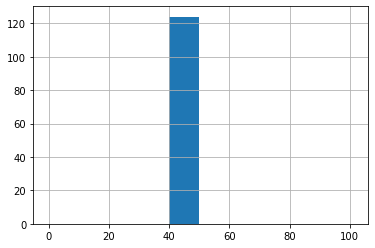

In [639]:
train_ratings3.groupby("user_id").count()["serie_id"].hist(bins=[0,5,10,20,30,40,50,60,70,101])

In [640]:
data3 = Dataset.load_from_df(train_ratings3[['user_id', 'serie_id', 'rating']], Reader(rating_scale=(1, 10)))

In [641]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [200, 300, 400,500, 600], 'lr_all': [0.0001, 0.0003, 0.0002],}

In [642]:
gs3 = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs3.fit(data3)
# best RMSE score
print("Meilleur résultat du RMSE:" , gs3.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print("Meilleur paramètres du RMSE:" ,gs3.best_params['rmse'])

Meilleur résultat du RMSE: 1.9449213653256177
Meilleur paramètres du RMSE: {'n_epochs': 500, 'lr_all': 0.0002}


In [643]:
pd.DataFrame.from_dict(gs3.cv_results)[["rank_test_rmse", "params","mean_test_rmse","std_test_rmse" ]].sort_values("rank_test_rmse")

rank_test_rmse                               params  mean_test_rmse  \
11               1  {'n_epochs': 500, 'lr_all': 0.0002}        1.944921   
7                2  {'n_epochs': 400, 'lr_all': 0.0003}        1.946102   
14               3  {'n_epochs': 600, 'lr_all': 0.0002}        1.947598   
8                4  {'n_epochs': 400, 'lr_all': 0.0002}        1.948051   
4                5  {'n_epochs': 300, 'lr_all': 0.0003}        1.948119   
12               6  {'n_epochs': 600, 'lr_all': 0.0001}        1.951085   
10               7  {'n_epochs': 500, 'lr_all': 0.0003}        1.953219   
1                8  {'n_epochs': 200, 'lr_all': 0.0003}        1.956176   
13               9  {'n_epochs': 600, 'lr_all': 0.0003}        1.959342   
5               10  {'n_epochs': 300, 'lr_all': 0.0002}        1.959744   
9               11  {'n_epochs': 500, 'lr_all': 0.0001}        1.966072   
2               12  {'n_epochs': 200, 'lr_all': 0.0002}        1.979721   
6               13  {'n_epochs': 400, 'lr_all': 0.0001}        1.983924   
3               14  {'n_epochs': 300, 'lr_all': 0.0001}        2.004186   
0               15  {'n_epochs': 200, 'lr_all': 0.0001}        2.048247   

    std_test_rmse  
11       0.037438  
7        0.033168  
14       0.032222  
8        0.030332  
4        0.031875  
12       0.029806  
10       0.034158  
1        0.028134  
13       0.033210  
5        0.024090  
9        0.029908  
2        0.024641  
6        0.026175  
3        0.019742  
0        0.019824

In [644]:
BaselineModel3 = BaselineOnly()
BaselineModel3.fit(data3.build_full_trainset())
svcModel3 = SVD(n_epochs=500, lr_all = 0.0002)         
svcModel3.fit(data3.build_full_trainset())
KNNmodel3 = KNNBasic(sim_options=sim_options)
KNNmodel3.fit(data3.build_full_trainset())
test_ratings["knn_prediction"] = [model_rating_pred(KNNmodel3,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]
test_ratings["svd_prediction"] = [model_rating_pred(svcModel3,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]
test_ratings["opt_bl_prediction"] = [model_rating_pred(BaselineModel3,user,mid) for user, mid in test_ratings[["user_id","serie_id"]].values]
test_ratings["mean_prediction"] = test_ratings[["user_id","serie_id"]].apply(mean_rating_pred,axis=1)
test_ratings["muser_prediction"] = test_ratings[["user_id","serie_id"]].apply(user_mean_rating_pred,axis=1) 
test_ratings["mitem_prediction"] = test_ratings[["user_id","serie_id"]].apply(item_mean_rating_pred,axis=1) 
metrics = ["mae","mse","rmse"]
results3 = pd.DataFrame()

results3["metrics"] = metrics

results3["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results3["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results3["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results3["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["rating"])
results3["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["rating"])
results3["knn_prediction"] = all_metrics(test_ratings["knn_prediction"],test_ratings["rating"])

results3 = results3.set_index("metrics")

print(results3)
print("")
print('---Best Models / Metrics: ---')
results3.idxmin(1)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.713695          1.451851          1.555734   
mse             4.760758          3.699888          4.049737   
rmse            2.181916          1.923509          2.012396   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               1.401199        1.168892        1.498215  
mse               3.424441        2.595636        4.215422  
rmse              1.850524        1.611098        2.053149  

---Best Models / Metrics: ---


metrics
mae     svd_prediction
mse     svd_prediction
rmse    svd_prediction
dtype: object

## Valeur des métriques pour les différents modèles selon les 3 Éxpériences :

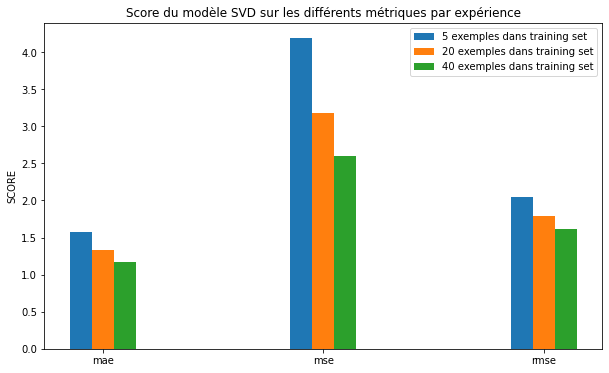

In [646]:
width = 0.1
fig, ax = plt.subplots(figsize=(10,6))

labels = ['mae', 'mse', 'rmse']
bar_test1 = results1["svd_prediction"]
bar_test2 = results2["svd_prediction"]
bar_test3 = results3["svd_prediction"]
x = np.arange(len(labels)) 

ax.bar(x - width, bar_test1, width, label='5 exemples dans training set')
ax.bar(x , bar_test2, width, label='20 exemples dans training set')
ax.bar(x+ width, bar_test3, width, label="40 exemples dans training set")

ax.set_ylabel('SCORE')
ax.set_title('Score du modèle SVD sur les différents métriques par expérience')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

In [647]:
al, g = util_mrr (train_ratings3, test_ratings)
rel_list = build_relevance_list (svcModel3 , g, al, existing_items)
svd_mrr3 = mrr(rel_list)
f"On average, the {int(round(1/svd_mrr3,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 10th proposed item is relevant (on 2087)'

In [809]:
print("On average, the {} proposed item is relevant (on {}) : Classe 5 avis dans le train'".format(int(round(1/svd_mrr1,0)), {len(existing_items)})) 
print("On average, the {} proposed item is relevant (on {}) : Classe 20 avis dans le train'".format(int(round(1/svd_mrr2,0)), {len(existing_items)}))
print("On average, the {} proposed item is relevant (on {}) : Classe 40 avis dans le train'".format(int(round(1/svd_mrr3,0)), {len(existing_items)}))

On average, the 14 proposed item is relevant (on {2087}) : Classe 5 avis dans le train'
On average, the 9 proposed item is relevant (on {2087}) : Classe 20 avis dans le train'
On average, the 10 proposed item is relevant (on {2087}) : Classe 40 avis dans le train'


### Résultat 3: 
- En moyenne, on aura besoin de 10 essais pour recommander une série pertinente parmi les 2087 séries existantes.
- Le SVD est le modèle à utiliser quand on a suffisamment de données.

## Analyse récapitulatif de tous les résultats:
- Plus de données signifie une meilleure performance sur les tous les métriques pour le SVD et le KNN.
- Les baselines sont très difficiles à battre quand on n’a pas assez de données avec les modèles collaboratifs.
- Pour le cold-start, les modèles collabortifs performent mal, on favorise dans ce cas d’autres approches plus adaptées ( Modèles basés sur le contenu ou hybrides).

## Protocol 2 : 

Dans ce protocole, on se mettra dans une situation de cold-
start. On fixera le nombre d’avis pris par utilisateur à 5 avis. On va en-
suite comparer les performances des deux modèles : le modèle basé sur
le contenu et le modèle hybride. Pour l’évaluation, on gardera les memes
avis et le meme nombre d’avis par utilisateur dans le test set que celui des
éxpériences précédentes.

### Objectif :
Comparer les performances des deux modèles (Content-Based) et (Hybrid) et déterminer le meilleur pour une configuration de cold-strat.

## Content Based Recommandation :

In [718]:
def series_bien_notes(reviews, user_id, k=10):
    """prend un user_id et retourne les id_séries qui a noté de 10/10"""
    res=reviews[(reviews["user_id"]==user_id) & (reviews["rating"].isin(list(range(k,11))))]  
    return res["serie_id"].unique()

def serie_to_repVect(nomFichier,path):
    """prend un nom de série et nous retourne sa presentation vectorielle avec notre preprocessing"""
    seriefile = join(path,nomFichier)
    p=open(seriefile, 'rb') 
    for i in range(4):   
        data = pickle.load(p)
    
    return data 


In [774]:
from os import listdir
from os.path import isfile, join
from collections import OrderedDict
from sklearn.metrics import pairwise_distances

path=r"C:\Users\yacin\Desktop\projet de recherche\ressources\series"
fichiersRepresentation = [f for f in listdir(path) if isfile(join(path, f))]
idSeriesFichierRepresentation = OrderedDict()
for f in fichiersRepresentation : 
    nom_serie = re.sub("[_]+|^[\d]+|.pkl$|\(.*\)|BBC", " ", f).strip()
    if nom_serie in serie_ID:
        idSeriesFichierRepresentation[serie_ID[nom_serie]] = np.array(serie_to_repVect(f ,path = path)).flatten()
len(idSeriesFichierRepresentation) 

811

In [775]:
d = pd.DataFrame.from_dict(idSeriesFichierRepresentation, orient="index", )
d.index=idSeriesFichierRepresentation.keys()


Pourquoi les 2 prochaines cellules ?
- C'est pour supprimer les vecteurs presque nulles dont la somme est inférieur à un certain seuil, ici 11

In [776]:
somme = []
for ID in idSeriesFichierRepresentation:
    somme.append(idSeriesFichierRepresentation[ID].sum())
    
pd.Series(somme).hist()

<AxesSubplot:>

In [777]:
listID = []
for ID in idSeriesFichierRepresentation:
    if idSeriesFichierRepresentation[ID].sum() < 11:
        listID.append(ID)
        
for ID in listID:
    del idSeriesFichierRepresentation[ID]

In [778]:
print(len(idSeriesFichierRepresentation))

704


In [779]:
def distance_matrix (idRepresentation, metric="cosine"):
    vecteurs = pd.DataFrame.from_dict(idRepresentation, orient="index")
    vecteurs.index=idRepresentation.keys()
    dis = pd.DataFrame(pairwise_distances(vecteurs, metric = metric ,n_jobs=-1))
    dis.index = vecteurs.index
    return dis
            
    
    
mtrx =  distance_matrix (idSeriesFichierRepresentation, metric="cosine")
mtrx

0             1         2             3         4         5    \
1362  2.331468e-15  4.031818e-01  0.384445  2.856801e-01  0.403832  0.261312   
444   4.031818e-01  4.996004e-15  0.441479  4.435328e-01  0.503420  0.408283   
1057  3.844450e-01  4.414787e-01  0.000000  3.521121e-01  0.482046  0.393237   
1297  2.856801e-01  4.435328e-01  0.352112  8.881784e-16  0.407590  0.331070   
1588  4.038321e-01  5.034197e-01  0.482046  4.075901e-01  0.000000  0.455413   
...            ...           ...       ...           ...       ...       ...   
141   2.515428e-01  3.527435e-01  0.154913  2.910239e-01  0.402567  0.281142   
1035  2.843719e-01  3.849692e-01  0.321010  3.488031e-01  0.469280  0.357634   
1736  2.672123e-01  3.900243e-01  0.238573  2.450745e-01  0.377091  0.343722   
1844  2.667195e-01  3.769690e-01  0.449008  3.176987e-01  0.474019  0.315166   
200   1.838934e-01  3.778714e-01  0.253344  2.137720e-01  0.348720  0.266011   

           6         7         8         9    ...       694       695  \
1362  0.216012  0.232726  0.305078  0.226618  ...  0.325694  0.387490   
444   0.340454  0.389139  0.404778  0.322082  ...  0.362458  0.535793   
1057  0.364731  0.345073  0.420410  0.199116  ...  0.422188  0.481315   
1297  0.266514  0.267910  0.288668  0.259925  ...  0.396079  0.406380   
1588  0.396800  0.383332  0.402810  0.381527  ...  0.434167  0.519346   
...        ...       ...       ...       ...  ...       ...       ...   
141   0.234402  0.211961  0.307433  0.064170  ...  0.308921  0.416290   
1035  0.219651  0.253702  0.350031  0.173144  ...  0.359051  0.438761   
1736  0.209448  0.208758  0.299249  0.120615  ...  0.313976  0.436837   
1844  0.228774  0.330327  0.350986  0.318813  ...  0.347589  0.470508   
200   0.191930  0.124759  0.256259  0.115009  ...  0.300712  0.326604   

           696       697       698       699       700           701  \
1362  0.341189  0.408240  0.293861  0.251543  0.284372  2.672123e-01   
444   0.408301  0.434706  0.432834  0.352743  0.384969  3.900243e-01   
1057  0.157947  0.405820  0.369097  0.154913  0.321010  2.385734e-01   
1297  0.321275  0.431649  0.268677  0.291024  0.348803  2.450745e-01   
1588  0.443548  0.505890  0.383609  0.402567  0.469280  3.770911e-01   
...        ...       ...       ...       ...       ...           ...   
141   0.146223  0.358431  0.282796  0.000000  0.186561  1.524813e-01   
1035  0.274725  0.394541  0.358634  0.186561  0.000000  2.497267e-01   
1736  0.216198  0.370815  0.256621  0.152481  0.249727  3.774758e-15   
1844  0.403306  0.439660  0.327755  0.355803  0.364570  3.309830e-01   
200   0.226686  0.338346  0.226972  0.141146  0.216507  1.235382e-01   

           702       703  
1362  0.266719  0.183893  
444   0.376969  0.377871  
1057  0.449008  0.253344  
1297  0.317699  0.213772  
1588  0.474019  0.348720  
...        ...       ...  
141   0.355803  0.141146  
1035  0.364570  0.216507  
1736  0.330983  0.123538  
1844  0.000000  0.282449  
200   0.282449  0.000000  

[704 rows x 704 columns]

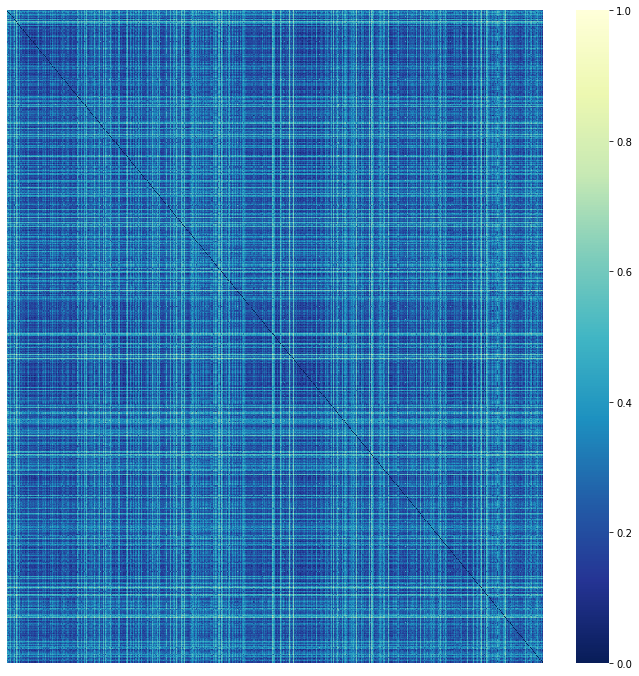

In [780]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(mtrx.values, cmap="YlGnBu_r",xticklabels=False, yticklabels=False, vmin=0, vmax=1)

In [789]:
def content_based_model(user_id, matrix, k ,reviews, note = 10, ):
    tab=[]
    already_seen =(reviews.groupby("user_id")["serie_id"]
                        .apply(list)
                        .to_dict())
    already_seen = already_seen[user_id]
    #print("already_seen", already_seen)
    series_ids=series_bien_notes(reviews,user_id, k=note)#uniqmnt celle de train
    #print("series_bien_notes",series_ids)
    for ids in series_ids:
        if ids in matrix.index : 
            tab.append([matrix.index[ind] for ind in np.argsort(matrix.loc[ids,:])[:k]])
    #print("tab", tab)
    stop = False
    ind = 0
    added = False
    recommandations = []
    rec = None
    while not stop and len(tab) >0:
        if len(tab)> ind:
            if len(tab[ind]) >0:
                rec = tab[ind].pop(0)
                added = True
                if not rec in already_seen and not rec in recommandations:
                    recommandations.append(rec)
            ind +=1
        else:
            if added : #Si j'ai fait un tour sur les listes et j'ai pas rajouté d'élements dans recommandations
                ind = 0
                added = False
            else:
                stop = True
        if len(recommandations) == k:
            stop = True
        
    return recommandations

In [790]:
content_based_model(997, mtrx,5, reviews2, note=5 )

[1271, 263, 1330, 1058, 1031]

In [791]:
a,g=util_mrr(train_ratings1, test_ratings)

In [792]:
test_ratings.groupby(by="user_id").count()["rating"].describe()

count    124.0
mean      20.0
std        0.0
min       20.0
25%       20.0
50%       20.0
75%       20.0
max       20.0
Name: rating, dtype: float64

In [793]:
list_of_rell = []
for user,will_see in g.items():
    rel_list = []
    will_see = set(will_see)
    if user in a:
        has_seen = set(a[user])
    
        can_see = content_based_model(user, mtrx, 10000 ,train_ratings1, note = 5, )
        for movie in can_see:
            if movie in will_see:
                rel_list.append(1)
                break
            else:
                rel_list.append(0)       
        if len(rel_list) <1:
            rel_list.append(0)
        #rel_list[-1] = 1 # when no relevant item exist
        #print(rel_list)
        list_of_rell.append(rel_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [794]:
svd_mrr = mrr(list_of_rell)
#print(svd_mrr)
f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 18th proposed item is relevant (on 2087)'

In [795]:
a2,g2=util_mrr(train_ratings2, test_ratings)

In [796]:
list_of_rel2= []
for user,will_see in g2.items():
    rel_list = []
    will_see = set(will_see)
    if user in a2:
        has_seen = set(a2[user])
    can_see = content_based_model(user, mtrx, 10000 ,train_ratings2, note = 8, )

    for movie in can_see:
        if movie in will_see:
            rel_list.append(1)       
            break
        else:
            rel_list.append(0)        
    if len(rel_list) <1:
        rel_list.append(0)
    #rel_list[-1] = 1 # when no relevant item exist
    list_of_rel2.append(rel_list)

In [797]:
svd_mrr = mrr(list_of_rel2)
#print(svd_mrr)
f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 28th proposed item is relevant (on 2087)'

## Hybrid Recommander system :

   Dans cette approches on essaye d’exploiter l’information disponible dans
la Matrice des avis des utilisateurs (approche collaboratif), mais aussi de
prendre en compte les similarités entre séries (approche du Content based).
Pour cela, on a construit un score qui combine les distances entre les
différentes séries et les informations tirées de la matrice des avis (ici c’est la note prédite par un modèle KNN basé utilisateurs entrainé sur toute la matrice des avis). 

Pour ensuite classer les séries selon ce nouveau score. La formule utilisée est :

    scores = (1 - distance)*score_KNN

In [798]:
def hybrid_recommander_system (user_id, matrix, k ,reviews, KNNmodel, note = 10, ):
    tab=[]
    epsilon = 0.0001
    
    # Prediction du modèle KNN sur l'espace des utilisateurs
    
    scores_knn = np.array([model_rating_pred(KNNmodel,user_id,mid) for mid in matrix.index], ).reshape((1,-1))
        
    already_seen =(reviews.groupby("user_id")["serie_id"]
                        .apply(list)
                        .to_dict())
    already_seen = already_seen[user_id]
    series_ids = series_bien_notes(reviews,user_id, k=note)   
    series_ids = [s for s in series_ids if s in matrix.index]   #on filtre les séries dont on n'a pas la représentation
    
    distances = matrix.loc[series_ids,:].values
    print("Matrice des distances : ", type(distances) , distances.shape)
    #print("series_bien_notes",series_ids)
    try:  
        scores = np.max((1 - distances)*scores_knn, axis=0)
    except:
        scores = np.array([])
        
    print("Scores", scores.shape)
    
    recommandations = [ matrix.index[ind] for ind in np.argsort(scores)[::-1] if not matrix.index[ind] in already_seen ]
        
    return recommandations

In [799]:
a2,g2=util_mrr(train_ratings2, test_ratings)

In [806]:
list_of_rel2= []
data = Dataset.load_from_df(train_ratings2[['user_id', 'serie_id', 'rating']], Reader(rating_scale=(1, 10)))
    
KNNmodel = KNNBasic(sim_options=sim_options)
KNNmodel.fit(data.build_full_trainset())


for user,will_see in g2.items():
    rel_list = []
    will_see = set(will_see)
    if user in a2:
        has_seen = set(a2[user])
    can_see = hybrid_recommander_system(user, mtrx, 10000 ,train_ratings2, KNNmodel, note = 7, )
    print(len(can_see))
    
    for movie in can_see:
        if movie in will_see:
            print("movie", movie)
            rel_list.append(1)       
            break
        else:
            rel_list.append(0)        
    if len(rel_list) <1:
        rel_list.append(0)
    print(rel_list)
    #rel_list[-1] = 1 # when no relevant item exist
    list_of_rel2.append(rel_list)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Matrice des distances :  <class 'numpy.ndarray'> (4, 704)
Scores (704,)
696
movie 1882
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrice des distances :  <class 'numpy.ndarray'> (7, 704)
Scores (704,)
696
movie 1362
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (7, 704)
Scores (704,)
696
movie 1282
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (5, 704)
Scores (704,)
695
movie 572
[0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (2, 704)
Scores (704,)
699
movie 1664
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (8, 704)
Scores (704,)
694
movie 1587
[

Matrice des distances :  <class 'numpy.ndarray'> (9, 704)
Scores (704,)
695
movie 126
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (7, 704)
Scores (704,)
696
movie 447
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Matrice des distances :  <class 'numpy.ndarray'> (6, 704)
Scores (704,)
698
movie 1321
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice d

Matrice des distances :  <class 'numpy.ndarray'> (5, 704)
Scores (704,)
697
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

694
movie 1975
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (7, 704)
Scores (704,)
695
movie 217
[0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (4, 704)
Scores (704,)
699
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Matrice des distances :  <class 'numpy.ndarray'> (7, 704)
Scores (704,)
697
movie 471
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (5, 704)
Scores (704,)
699
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrice des distances :  <class 'numpy.ndarray'> (5, 704)
Scores (704,)
699
movie 860
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (2, 704)
Scores (704,)
696
movie 724
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

696
movie 1306
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (5, 704)
Scores (704,)
699
movie 1601
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Matrice des distances :  <class 'numpy.ndarray'> (9, 704)
Scores (704,)
693
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [807]:
svd_mrr = mrr(list_of_rel2)
#print(svd_mrr)
f"On average, the {int(round(1/svd_mrr,0))}th proposed item is relevant (on {len(existing_items)})"

'On average, the 17th proposed item is relevant (on 2087)'

## Résultats : 
- La MRR rapporté pour le modèle basé sur le contenu : En moyenne, on aura besoin de 28 essais pour recommander une série pertinente parmi les 2087 séries existantes.
- La MRR rapporté pour le modèle hybride : En moyenne, on aura besoin de 17 essais pour recommander une série pertinente parmi les 2087 séries existantes.

## Récapitulatif :
Dans une configuration de cold-start, le modèle hybride qu’on a conçu est meilleur que celui basé sur le contenu pour des taches de recommandation.